In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import  Dense
from keras.models import Sequential
from keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,accuracy_score
random_state = 10

In [24]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler

# Definir rutas
base_path = '/prj/posgrad/samuelrt/Documentos/Doutorado/images'
hombres_path = os.path.join(base_path, 'homen')
mujeres_path = os.path.join(base_path, 'mulher')

# Tamaño deseado para las imágenes
img_height, img_width = 128, 128  # Un tamaño más pequeño para reducir dimensionalidad

# Listas para almacenar imágenes y etiquetas
imagenes = []
etiquetas = []

# Cargar imágenes de hombres (etiqueta 0) en escala de grises
for imagen_nombre in os.listdir(hombres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(hombres_path, imagen_nombre)
        # Cargar imagen como escala de grises directamente
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Redimensionar
        img = cv2.resize(img, (img_width, img_height))
        # Aplanar la imagen (convertir matriz 2D a vector 1D)
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(0)  # 0 para hombres

# Cargar imágenes de mujeres (etiqueta 1) en escala de grises
for imagen_nombre in os.listdir(mujeres_path):
    if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(mujeres_path, imagen_nombre)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img_flat = img.flatten()
        imagenes.append(img_flat)
        etiquetas.append(1)  # 1 para mujeres

# Convertir listas a arrays de NumPy
X = np.array(imagenes)
y = np.array(etiquetas)

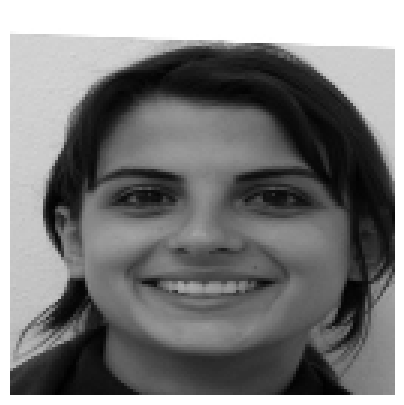

In [25]:
def visualizar_imagen(imagen_flat, altura=64, anchura=64):
    # Reformar el vector aplanado a matriz 2D
    imagen_2d = imagen_flat.reshape(altura, anchura)
    plt.figure(figsize=(5, 5))
    plt.imshow(imagen_2d, cmap='gray')
    plt.axis('off')
    plt.show()

# Para visualizar una imagen del conjunto de entrenamiento
indice = 0  # Cambia el índice para ver diferentes imágenes
visualizar_imagen(X[indice], img_height, img_width)

In [26]:
df = pd.DataFrame(data=X,columns=[f'P{i}' for i in range(X.shape[1])])
df.loc[:,'target'] = y
df
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P16375,P16376,P16377,P16378,P16379,P16380,P16381,P16382,P16383,target
0,255,255,255,255,255,255,255,255,255,255,...,130,130,130,131,133,139,139,139,143,0
1,165,167,167,166,167,167,167,172,166,166,...,147,147,147,145,145,137,127,121,119,0
2,187,188,185,185,185,187,188,184,185,183,...,44,54,52,42,42,44,58,59,67,0
3,255,255,255,255,255,255,255,255,255,255,...,13,13,17,20,21,20,21,26,29,0
4,195,191,191,192,194,191,191,193,193,192,...,10,6,12,30,30,30,32,37,42,0


In [27]:
df.value_counts(subset='target')

target
0    200
1    200
Name: count, dtype: int64

In [28]:
# Para obtener el mismo resultado aleatorio cada vez
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P16375,P16376,P16377,P16378,P16379,P16380,P16381,P16382,P16383,target
0,183,184,187,187,184,185,186,184,185,185,...,122,124,126,125,126,128,129,132,135,1
1,186,183,183,184,185,186,186,186,183,183,...,116,112,113,115,118,117,120,122,120,0
2,186,187,189,189,188,188,186,184,187,187,...,37,30,25,25,26,26,25,25,25,1
3,185,182,185,186,185,185,185,186,186,183,...,49,64,74,79,83,82,79,77,79,1
4,199,198,198,199,199,197,199,200,200,200,...,25,26,25,25,25,27,28,28,25,0


In [29]:
def scaler(x):
    return (x - np.mean(x)) / np.std(x)
    #return (x - np.min(x))/(np.max(x) - np.min(x))

In [30]:
X = df.values[:,:-1]
y = df.values[:,-1]

In [31]:
X = scaler(X)

Text(0.5, 1.0, 'Counts')

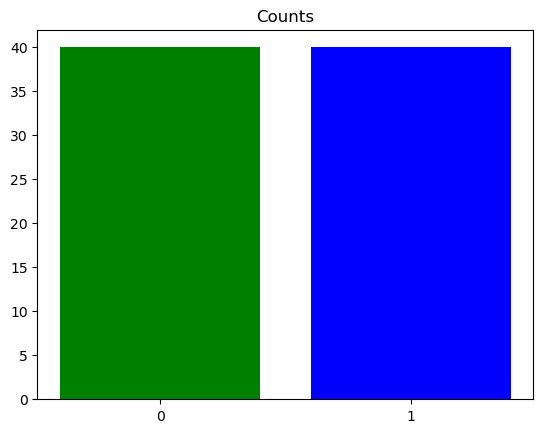

In [32]:
# Separar test y entrenamiento
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state,stratify=y)
clases ,count = np.unique(y_test,return_counts=True)
plt.bar(x=clases,height=count,color=['g','b'])
plt.xticks(clases)
plt.title('Counts')

In [33]:
print(X_test.shape)

(80, 16384)


### K-Fold

In [34]:
from sklearn.model_selection import KFold

K = 4
info = {} # store all the information obtained by the validation
kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
number = 0
for train_index, val_index in kf.split(X_trainval):
    x_train, x_val = X_trainval[train_index], X_trainval[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]
    # Entrenar modelo y evaluar...
    
    model = Sequential()
    model.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu',
                                        kernel_initializer='glorot_uniform'))

    # Agregar segunda capa oculta
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.01), metrics=['binary_accuracy'])

    # Train the perceptron using Adam optimizer
    history = model.fit(x_train, y_train, validation_data=(
                        x_val, y_val), epochs=10, batch_size=10,verbose=False)
    
    print(X_test.shape,'aqui')
    
    pred = model.predict(X_test).astype(int)
    
    accuracy = accuracy_score(pred,y_test)
    
    info[number] = [history.history['loss'],history.history['val_loss'],accuracy]
    number +=1

/prj/posgrad/samuelrt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(80, 16384) aqui
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/prj/posgrad/samuelrt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(80, 16384) aqui
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/prj/posgrad/samuelrt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(80, 16384) aqui
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/prj/posgrad/samuelrt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(80, 16384) aqui
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


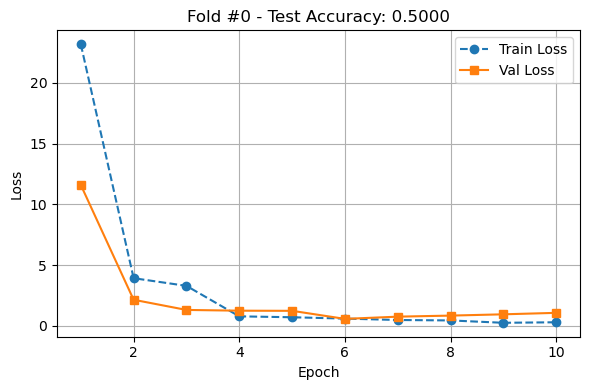

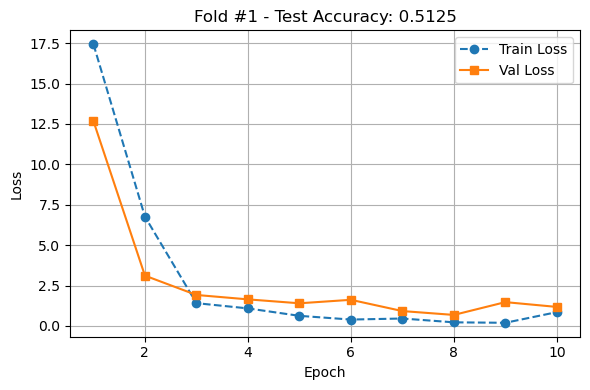

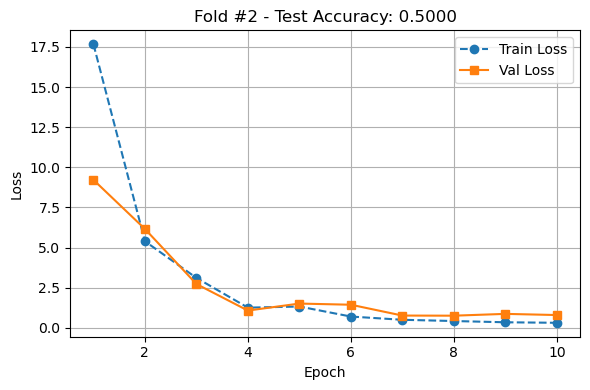

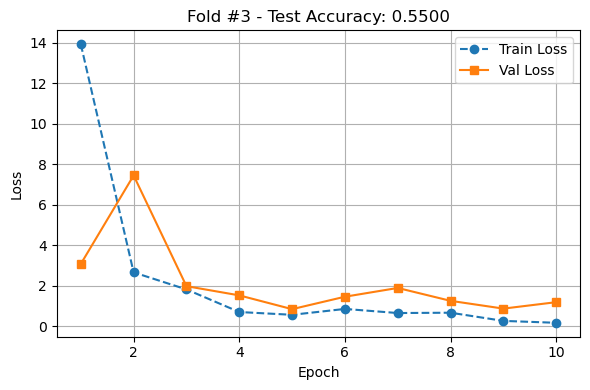

In [35]:

def plot_info(info):
    """
    Dibuja un gráfico separado para cada experimento almacenado en el diccionario `info`,
    mostrando la pérdida de entrenamiento y validación por época, e incluyendo la precisión
    final sobre el conjunto de test en el título.

    Parameters
    ----------
    info : dict
        Diccionario donde cada clave es un identificador (e.g., fold o experimento),
        y cada valor es una lista con:
        [train_loss_list, val_loss_list, accuracy_test]
    """
    for key, (train_loss, val_loss, acc) in info.items():
        epochs = list(range(1, len(train_loss) + 1))

        plt.figure(figsize=(6, 4))
        plt.plot(epochs, train_loss, 'o--', label="Train Loss")
        plt.plot(epochs, val_loss, 's-', label="Val Loss")

        plt.title(f"Fold #{key} - Test Accuracy: {acc:.4f}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_info(info)

[0.5, 0.5125, 0.5, 0.55]


/tmp/ipykernel_37644/1569475543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=names,y=acc,palette='viridis')


Text(0, 0.5, 'Accuracy')

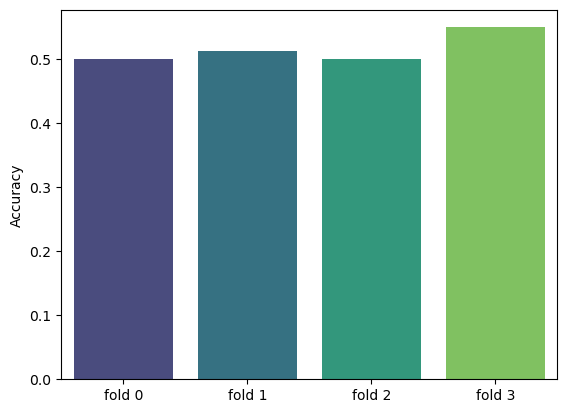

In [45]:
acc = [v[2] for v in info.values()]
print(acc)
names = [f'fold {i}' for i in range(len(acc))]
sb.barplot(x=names,y=acc,palette='viridis')
plt.ylabel('Accuracy')